# Import Libraries

In [23]:
import os
import time
import torch
import string
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from torchtext import data, datasets
from torchtext.vocab import GloVe
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense, LSTM, Embedding, Bidirectional, GRU, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import warnings
import logging
logging.basicConfig(level=logging.INFO)

%matplotlib inline

In [2]:
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data Exploration

In [3]:
# For tokenization
TEXT = data.Field(tokenize='spacy',
                  tokenizer_language='en_core_web_sm',
                  include_lengths=True)
# For multi-class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

In [4]:
# Split training data into train and validation sets
train_data, valid_data = train_data.split(split_ratio=0.8)

print("Train size (after splitting):", len(train_data.examples))
print("Validation size:", len(valid_data.examples))
print("Test size:", len(test_data.examples))

Train size (after splitting): 4362
Validation size: 1090
Test size: 500


Unique labels in training data: ['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
Counts: {'NUM': 718, 'HUM': 964, 'ENTY': 994, 'DESC': 953, 'LOC': 662, 'ABBR': 71}
Num unique: 6


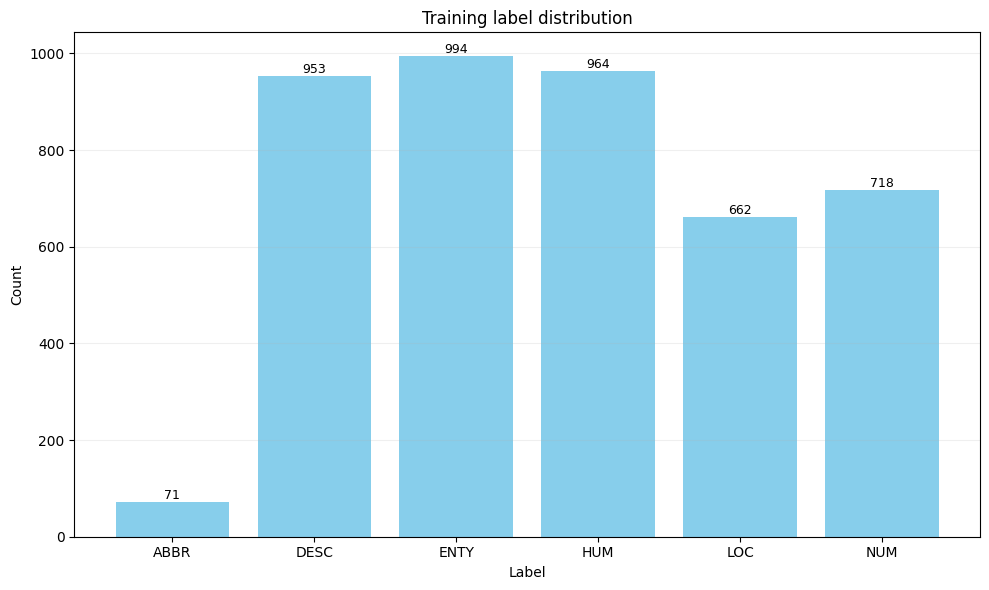

In [5]:
labels = [ex.label for ex in train_data.examples]
unique_labels = sorted(set(labels))
counts = Counter(labels)
bars = [counts[label] for label in unique_labels]

print("Unique labels in training data:", unique_labels)
print("Counts:", dict(counts))
print("Num unique:", len(unique_labels))

# Plotting the label distribution
plt.figure(figsize=(10,6))
bar_plots = plt.bar(unique_labels, bars, color='skyblue')
plt.title("Training label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
# plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

# Add counts on top of bars
for rect, cnt in zip(bar_plots, bars):
    y = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, y, str(cnt),
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

Unique labels in validation data: ['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
Counts: {'HUM': 259, 'ENTY': 256, 'DESC': 209, 'NUM': 178, 'LOC': 173, 'ABBR': 15}
Num unique: 6


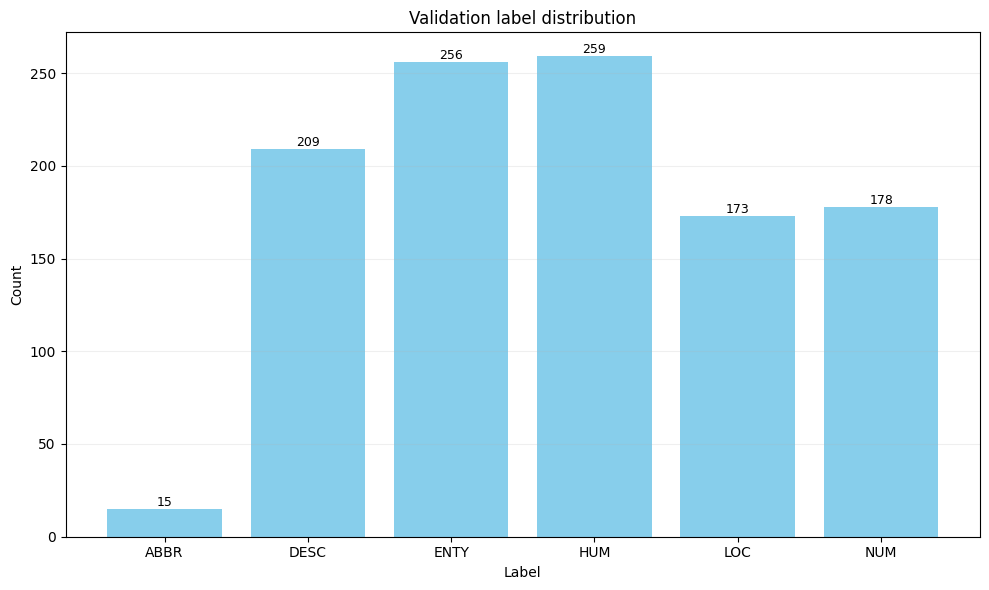

In [6]:
labels = [ex.label for ex in valid_data.examples]
unique_labels = sorted(set(labels))
counts = Counter(labels)
bars = [counts[label] for label in unique_labels]

print("Unique labels in validation data:", unique_labels)
print("Counts:", dict(counts))
print("Num unique:", len(unique_labels))

# Plotting the label distribution
plt.figure(figsize=(10,6))
bar_plots = plt.bar(unique_labels, bars, color='skyblue')
plt.title("Validation label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
# plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

# Add counts on top of bars
for rect, cnt in zip(bar_plots, bars):
    y = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, y, str(cnt),
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

Unique labels in test data: ['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
Counts: {'NUM': 113, 'LOC': 81, 'HUM': 65, 'DESC': 138, 'ENTY': 94, 'ABBR': 9}
Num unique: 6


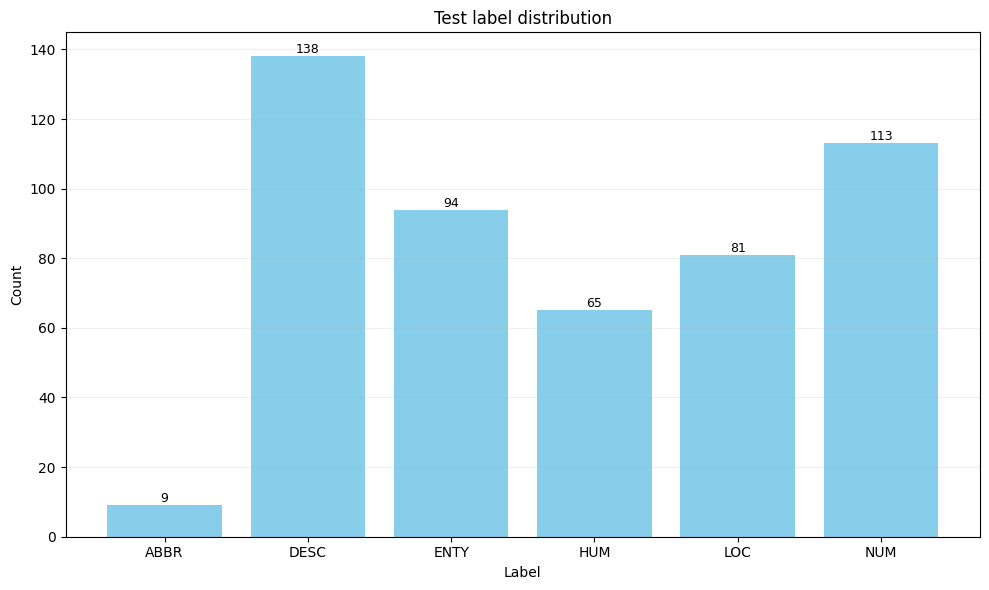

In [7]:
labels = [ex.label for ex in test_data.examples]
unique_labels = sorted(set(labels))
counts = Counter(labels)
bars = [counts[label] for label in unique_labels]

print("Unique labels in test data:", unique_labels)
print("Counts:", dict(counts))
print("Num unique:", len(unique_labels))

# Plotting the label distribution
plt.figure(figsize=(10,6))
bar_plots = plt.bar(unique_labels, bars, color='skyblue')
plt.title("Test label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
# plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

# Add counts on top of bars
for rect, cnt in zip(bar_plots, bars):
    y = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, y, str(cnt),
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Data Augmentation + Preprocessing

In [13]:
example = train_data.examples[0].text
print("Example text:", example)

sentence = " ".join(example)
print("Example sentence:", sentence)

Example text: ['How', 'many', 'spears', 'are', 'there', 'on', 'Kenya', "'s", 'flag', '?']
Example sentence: How many spears are there on Kenya 's flag ?


In [ ]:
# Usage of T5 Paraphrasing Model
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

example = train_data.examples[0].text
sentence = " ".join(example)

text = "Paraphrase: " + sentence

encoding = tokenizer.encode_plus(text,
                                 padding="max_length",
                                 return_tensors="pt",
                                 truncation=True,
                                 max_length=256)
encoding = {key: val.to(device) for key, val in encoding.items()}

with torch.no_grad():
    outputs = model.generate(input_ids=encoding['input_ids'],
                            attention_mask=encoding['attention_mask'],
                            max_length=256,
                            do_sample=True,
                            top_k=200,
                            top_p=0.95,
                            num_beams=5,
                            early_stopping=True,
                            num_return_sequences=5)

for output in outputs:
    paraphrased_sentence = tokenizer.decode(output, skip_special_tokens=True)
    print("Paraphrased sentence:", paraphrased_sentence)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--t5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Paraphrased sentence: How many spears are there on the flag of Kenya ?
Paraphrased sentence: How many spears are on the flag of Kenya ?
Paraphrased sentence: How many spears are there on Kenya 's flag ?
Paraphrased sentence: How many spears are on Kenya 's flag ?
Paraphrased sentence: How many spears on the flag of Kenya are there ?


In [24]:
# Data augmentation using T5 model
def augment_sentence(sentence, num_augments=5):
    text = "Paraphrase: " + sentence

    encoding = tokenizer.encode_plus(text,
                                     padding="max_length",
                                     return_tensors="pt",
                                     truncation=True,
                                     max_length=256)
    encoding = {key: val.to(device) for key, val in encoding.items()}

    with torch.no_grad():
        outputs = model.generate(input_ids=encoding['input_ids'],
                                attention_mask=encoding['attention_mask'],
                                max_length=256,
                                do_sample=True,
                                top_k=200,
                                top_p=0.95,
                                num_beams=1, # Pure sampling without beam search
                                num_return_sequences=num_augments)

    augmented_sentences = []
    for output in outputs:
        paraphrased_sentence = tokenizer.decode(output, skip_special_tokens=True)
        augmented_sentences.append(paraphrased_sentence)
    
    return augmented_sentences

In [25]:
def to_sentence(tokens):
    return " ".join(tokens) if isinstance(tokens, list) else str(tokens)

# 1) Collect training texts by label
per_label_texts = defaultdict(list)
for ex in train_data.examples:
    per_label_texts[ex.label].append(to_sentence(ex.text))

print("Train counts before:", {k: len(v) for k, v in per_label_texts.items()})

TARGET_PER_CLASS = 1000
rng = random.Random(42)

aug_texts, aug_labels = [], []

def normalize(s: str) -> str:
    return " ".join(s.strip().split()).lower()

Train counts before: {'NUM': 718, 'HUM': 964, 'ENTY': 994, 'DESC': 953, 'LOC': 662, 'ABBR': 71}


In [26]:
# 2) For each label, add paraphrases across as many unique base samples as possible
for label, texts in per_label_texts.items():
    need = max(0, TARGET_PER_CLASS - len(texts))
    if need == 0:
        continue

    # Dedup within class (avoid adding exact duplicates)
    seen = {normalize(t) for t in texts}

    n = len(texts)
    rounds, rem = divmod(need, n)
    idx_all = list(range(n))

    # Full rounds: each base sentence gets one paraphrase per round
    for _ in range(rounds):
        for i in idx_all:
            base = texts[i]
            # Try a few times to get a fresh paraphrase
            paraphrase = None
            for _try in range(3):
                try:
                    outs = augment_sentence(base, num_augments=1)
                    if outs:
                        cand = outs[0]
                        if normalize(cand) not in seen and normalize(cand) != normalize(base):
                            paraphrase = cand
                            break
                except Exception:
                    continue
            if paraphrase is None:
                # Fallback: accept first output if available, even if duplicate
                try:
                    outs = augment_sentence(base, num_augments=1)
                    paraphrase = outs[0] if outs else base
                except Exception:
                    paraphrase = base

            seen.add(normalize(paraphrase))
            aug_texts.append(paraphrase)
            aug_labels.append(label)

    # Remainder: randomly choose a subset of base samples and paraphrase each once
    rng.shuffle(idx_all)
    for i in idx_all[:rem]:
        base = texts[i]
        paraphrase = None
        for _try in range(3):
            try:
                outs = augment_sentence(base, num_augments=1)
                if outs:
                    cand = outs[0]
                    if normalize(cand) not in seen and normalize(cand) != normalize(base):
                        paraphrase = cand
                        break
            except Exception:
                continue
        if paraphrase is None:
            try:
                outs = augment_sentence(base, num_augments=1)
                paraphrase = outs[0] if outs else base
            except Exception:
                paraphrase = base

        seen.add(normalize(paraphrase))
        aug_texts.append(paraphrase)
        aug_labels.append(label)

In [27]:
# 3) Combine original + augmented train data
orig_texts = [to_sentence(ex.text) for ex in train_data.examples]
orig_labels = [ex.label for ex in train_data.examples]

train_texts_upsampled = orig_texts + aug_texts
train_labels_upsampled = orig_labels + aug_labels

In [28]:
# Print one augmented example from each class
seen_labels = set()
for text, label in zip(aug_texts, aug_labels):
    if label not in seen_labels:
        print(f"Augmented example for class {label}: {text}")
        seen_labels.add(label)
    if len(seen_labels) == len(unique_labels):
        break

Augmented example for class NUM: What debts the Qintex Group left ?
Augmented example for class HUM: What is the nickname of the famous flyer who mistakenly flew to Ireland rather than to Los Angeles ?
Augmented example for class ENTY: Can you name Sarge 's dog in Beetle Bailey ?
Augmented example for class DESC: How do they produce vitamin ?
Augmented example for class LOC: What U.S. state is Mammoth Cave National Park ?
Augmented example for class ABBR: What is the abbreviated term for the National Bureau of Investigation used ?


In [29]:
# 4) Show new distribution
new_counts = Counter(train_labels_upsampled)
print("Train counts after:", dict(new_counts))

Train counts after: {'NUM': 1000, 'HUM': 1000, 'ENTY': 1000, 'DESC': 1000, 'LOC': 1000, 'ABBR': 1000}


In [33]:
# Rebuild torchtext Datasets using the same Fields (vocab stays the same)
fields = [("text", TEXT), ("label", LABEL)]

train_examples_upsampled = [
    data.Example.fromlist([t, y], fields)
    for t, y in zip(train_texts_upsampled, train_labels_upsampled)
]

train_data_upsampled = data.Dataset(train_examples_upsampled, fields)

In [34]:
# Tokenizer and Vocabulary with GloVe
TEXT.build_vocab(train_data_upsampled, vectors="glove.6B.100d")
LABEL.build_vocab(train_data_upsampled)

INFO:torchtext.vocab:Loading vectors from .vector_cache\glove.6B.100d.txt.pt


In [35]:
# Prepare embedding matrix with OOV strategies
embedding_dim = 100
vocab = TEXT.vocab
vectors = vocab.vectors.clone()
glove_vocab = set(vocab.stoi.keys())

# Subword parameters
ngram_min = 3
ngram_max = 6

# Count word frequency in training data
word_counter = Counter()
for example in train_data_upsampled:
    word_counter.update([w.lower().strip(string.punctuation) for w in example.text])

# Threshold to consider a word “frequent” (adjustable)
freq_threshold = 3

# <unk> vector
unk_vector = torch.zeros(embedding_dim)

# Counters
subword_count = 0
random_count = 0
unk_count = 0

def get_subwords(word, n_min=3, n_max=6):
    word = f"<{word.lower()}>"
    subwords = []
    for n in range(n_min, n_max+1):
        subwords += [word[i:i+n] for i in range(len(word)-n+1)]
    return subwords

def get_word_vector(word):
    global subword_count, random_count, unk_count
    w_clean = word.lower().strip(string.punctuation)
    
    if w_clean in glove_vocab:
        return vectors[vocab.stoi[w_clean]]
    
    # Subword averaging
    subwords = get_subwords(w_clean, ngram_min, ngram_max)
    subword_vecs = [vectors[vocab.stoi[sg]] for sg in subwords if sg in glove_vocab]
    if subword_vecs:
        subword_count += 1
        return torch.stack(subword_vecs).mean(0)
    
    # Random vector for frequent OOVs
    if word_counter[w_clean] >= freq_threshold:
        random_count += 1
        return torch.randn(embedding_dim)
    
    # <unk> for rare OOVs
    unk_count += 1
    return unk_vector

# Build embedding matrix
embedding_matrix = {}
for example in train_data_upsampled:
    for w in example.text:
        if w not in embedding_matrix:
            embedding_matrix[w] = get_word_vector(w)

In [36]:
# Convert torchtext Dataset -> raw texts, labels
def ds_to_texts_labels(ds):
    texts, labels = [], []
    for ex in ds.examples:
        t = ex.text
        if isinstance(t, list):
            t = " ".join(t)
        texts.append(t)
        labels.append(ex.label)
    return texts, labels

valid_texts, valid_labels = ds_to_texts_labels(valid_data)
test_texts,  test_labels  = ds_to_texts_labels(test_data)

In [37]:
# Tokenizer + sequences
MAX_VOCAB = globals().get("MAX_VOCAB", 20000)
MAX_LEN   = globals().get("MAX_LEN", 50)

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
tok.fit_on_texts(train_texts_upsampled)

X_train = pad_sequences(tok.texts_to_sequences(train_texts_upsampled), maxlen=MAX_LEN, padding="post", truncating="post")
X_valid = pad_sequences(tok.texts_to_sequences(valid_texts), maxlen=MAX_LEN, padding="post", truncating="post")
X_test  = pad_sequences(tok.texts_to_sequences(test_texts),  maxlen=MAX_LEN, padding="post", truncating="post")

In [39]:
# Labels -> one-hot
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(train_labels_upsampled))
y_valid = to_categorical(le.transform(valid_labels))
y_test  = to_categorical(le.transform(test_labels))
nclasses = y_train.shape[1]

In [40]:
# Build embedding_weights aligned to tok.word_index
vocab_size = min(MAX_VOCAB, len(tok.word_index) + 1)
embedding_dim = globals().get("embedding_dim", 100)

embedding_weights = np.zeros((vocab_size, embedding_dim), dtype="float32")

for w, i in tok.word_index.items():
    if i >= vocab_size:
        continue
    vec = None
    # Token vector from embedding_matrix
    if w in embedding_matrix:
        vec = embedding_matrix[w]
    else:
        # Try normalized lookup against torchtext vocab
        w_clean = w.lower().strip(string.punctuation)
        if hasattr(TEXT, "vocab") and w_clean in TEXT.vocab.stoi:
            vec = TEXT.vocab.vectors[TEXT.vocab.stoi[w_clean]]
        else:
            # Use OOV function (returns torch tensor)
            try:
                vec = get_word_vector(w)
            except Exception:
                vec = None

    # Convert to numpy if torch tensor
    if isinstance(vec, torch.Tensor):
        embedding_weights[i] = vec.cpu().numpy()
    elif isinstance(vec, np.ndarray):
        embedding_weights[i] = vec

In [41]:
# Ensure padding index 0 is zeros
embedding_weights[0] = np.zeros(embedding_dim, dtype=np.float32)

# Ensure OOV token has non-zero vector if possible
oov_idx = tok.word_index.get(tok.oov_token)
if oov_idx is not None and oov_idx < vocab_size:
    known = embedding_weights[(embedding_weights != 0).any(axis=1)]
    if known.size:
        embedding_weights[oov_idx] = known.mean(axis=0)

print("X_train.shape, X_valid.shape, X_test.shape:", X_train.shape, X_valid.shape, X_test.shape)
print("y_train.shape, nclasses, vocab_size:", y_train.shape, nclasses, vocab_size)

X_train.shape, X_valid.shape, X_test.shape: (6000, 50) (1090, 50) (500, 50)
y_train.shape, nclasses, vocab_size: (6000, 6) 6 7501


# BiLSTM Model with Regularization

In [42]:
def build_bilstm(nclasses, vocab_size, emb_dim, max_len, emb_weights):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=emb_dim,
                        input_length=max_len,
                        weights=[emb_weights],
                        trainable=True)) # Load embedding matrix as weights
    model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_bilstm(nclasses, vocab_size, embedding_dim, MAX_LEN, embedding_weights)

c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
class AdversarialTrainer(tf.keras.Model):
    def __init__(self, base_model, epsilon=0.5, alpha=0.5, mask_pad=True):
        super().__init__()
        self.base_model = base_model
        self.embed = base_model.layers[0]           # Embedding layer
        self.rest = base_model.layers[1:]           # The rest of the network
        self.epsilon = tf.constant(epsilon, dtype=tf.float32)
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.mask_pad = mask_pad

    def call(self, x, training=False):
        return self.base_model(x, training=training)

    def _forward_from_embeddings(self, emb, training=True):
        h = emb
        for layer in self.rest:
            h = layer(h, training=training)
        return h

    def train_step(self, data):
        x, y = data

        # 1) Compute perturbation η with a short tape (no weight updates)
        with tf.GradientTape() as tape_eta:
            emb = self.embed(x)                 # (B, T, D)
            tape_eta.watch(emb)
            y_pred_clean = self._forward_from_embeddings(emb, training=True)
            loss_clean = self.compiled_loss(y, y_pred_clean)  # no reg losses here

        grad = tape_eta.gradient(loss_clean, emb)             # outside the context
        norm = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(grad), axis=[1,2], keepdims=True), 1e-12))
        eta = self.epsilon * grad / norm

        if self.mask_pad:
            pad_mask = tf.cast(tf.not_equal(x, 0), emb.dtype)  # (B, T)
            pad_mask = tf.expand_dims(pad_mask, -1)            # (B, T, 1)
            eta = eta * pad_mask

        eta = tf.stop_gradient(eta)  # do not backprop through η construction

        # 2) Final loss and weight update with a fresh tape
        with tf.GradientTape() as tape:
            emb2 = self.embed(x)
            y_pred_clean2 = self._forward_from_embeddings(emb2, training=True)
            loss_clean2 = self.compiled_loss(y, y_pred_clean2, regularization_losses=self.base_model.losses)

            y_pred_adv = self._forward_from_embeddings(emb2 + eta, training=True)
            loss_adv = self.compiled_loss(y, y_pred_adv)

            loss = self.alpha * loss_clean2 + (1.0 - self.alpha) * loss_adv

        grads = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.base_model.trainable_variables))

        for metric in self.metrics:
            metric.update_state(y, y_pred_clean2)

        results = {m.name: m.result() for m in self.metrics}
        results["loss"] = loss
        return results

In [45]:
def plot_history(history):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    # Handle possible key names
    acc = h.get("accuracy", h.get("acc"))
    val_acc = h.get("val_accuracy", h.get("val_acc"))
    loss = h.get("loss")
    val_loss = h.get("val_loss")

    plt.figure(figsize=(10, 12))

    # Accuracy
    plt.subplot(2, 1, 1)
    if acc is not None:
        plt.plot(epochs, acc, label="train")
    if val_acc is not None:
        plt.plot(epochs, val_acc, label="val")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(2, 1, 2)
    if loss is not None:
        plt.plot(epochs, loss, label="train")
    if val_loss is not None:
        plt.plot(epochs, val_loss, label="val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [44]:
epsilon = 0.5   # try 0.1–2.0; tune per validation
alpha   = 0.5   # 0.5 means equal weight clean/adv
adv_model = AdversarialTrainer(model, epsilon=epsilon, alpha=alpha, mask_pad=True)

# Recompile (reuse your optimizer/loss/metrics)
opt = Adam(learning_rate=1e-3)
adv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

start_time = time.time()

# Train with the same data/callbacks
history = adv_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10, batch_size=64,
    callbacks=[es], verbose=1
)

end_time = time.time()
print("Training time:", end_time - start_time)

Epoch 1/10


c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\backend\tensorflow\trainer.py:673: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.5760 - loss: 0.9147 - val_accuracy: 0.7083 - val_loss: 0.7933
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.7940 - loss: 0.6192 - val_accuracy: 0.7972 - val_loss: 0.5898
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.8617 - loss: 0.4524 - val_accuracy: 0.8183 - val_loss: 0.4957
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9068 - loss: 0.3249 - val_accuracy: 0.8459 - val_loss: 0.4379
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9393 - loss: 0.2024 - val_accuracy: 0.8569 - val_loss: 0.4252
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9587 - loss: 0.1609 - val_accuracy: 0.8743 - val_loss: 0.4182
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9743 - loss: 0.1032 - val_accuracy: 0.8716 - val_loss: 0.4650
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9832 - loss: 0.0697 - val_accuracy: 0.8651 - val_loss: 0.

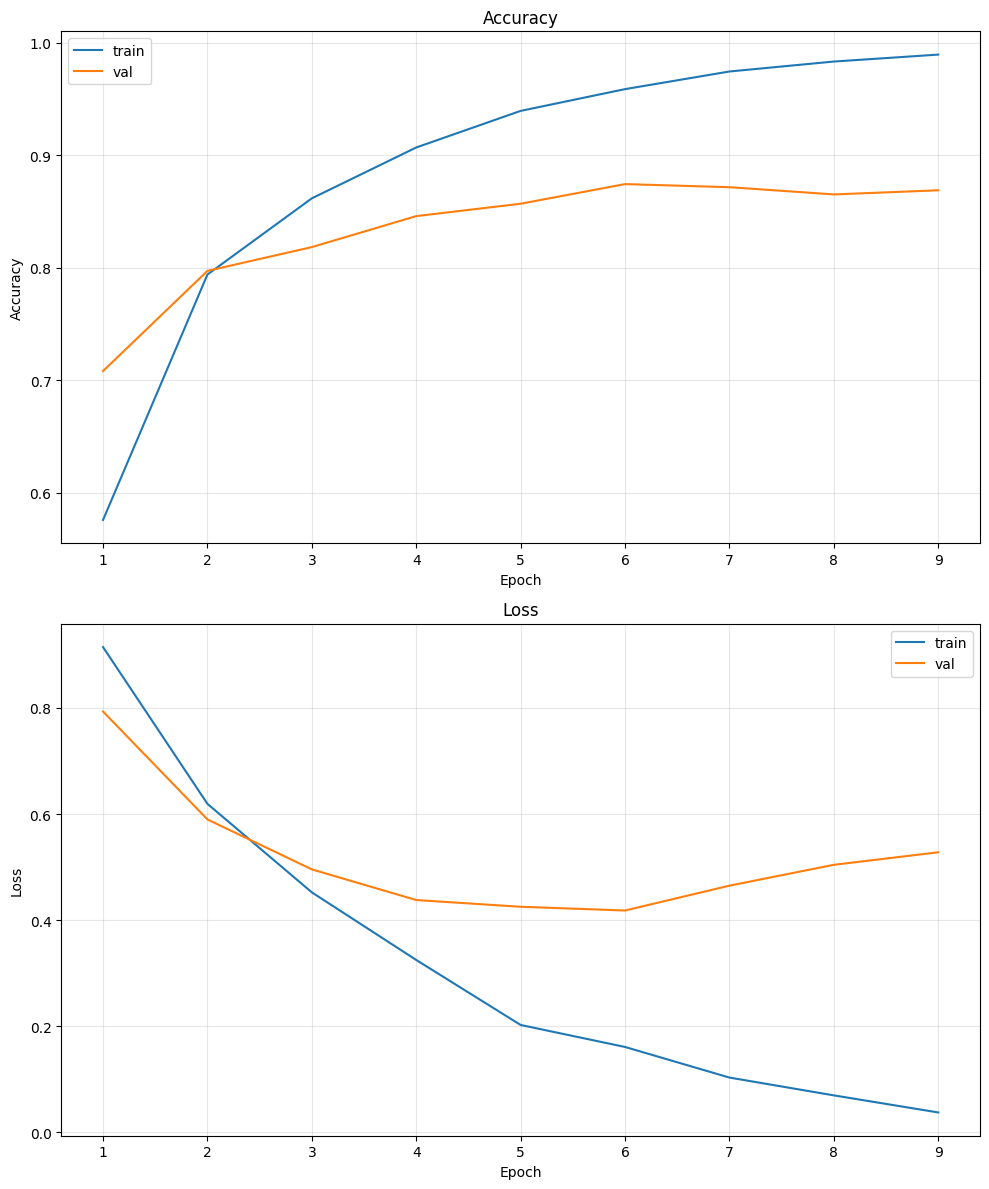

In [46]:
plot_history(history)

In [47]:
# Inference
y_pred = adv_model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step
Test accuracy: 0.902
              precision    recall  f1-score   support

        ABBR       0.88      0.78      0.82         9
        DESC       0.92      0.95      0.94       138
        ENTY       0.84      0.78      0.81        94
         HUM       0.87      0.94      0.90        65
         LOC       0.87      0.91      0.89        81
         NUM       0.97      0.93      0.95       113

    accuracy                           0.90       500
   macro avg       0.89      0.88      0.89       500
weighted avg       0.90      0.90      0.90       500



Topic-wise accuracy on test set:
ABBR: 0.7778 (n=9)
DESC: 0.9493 (n=138)
ENTY: 0.7766 (n=94)
HUM: 0.9385 (n=65)
LOC: 0.9136 (n=81)
NUM: 0.9292 (n=113)


<Figure size 1000x800 with 0 Axes>

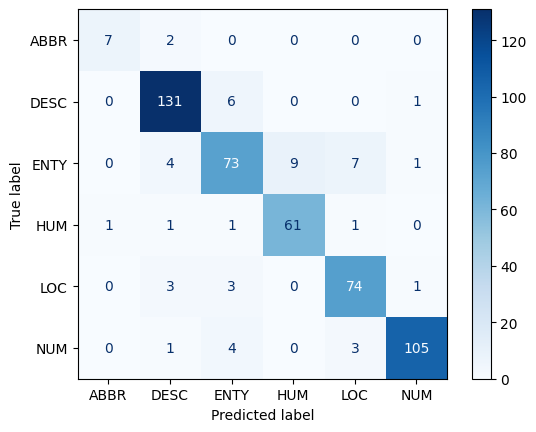

In [48]:
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

print("Topic-wise accuracy on test set:")

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Plot the confusion matrix
plt.figure(figsize=(10,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = le.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [49]:
# Save weights
adv_model.save_weights('bilstm_adv_model_v2.weights.h5')

In [50]:
adv_model.summary()

Model: "adversarial_trainer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 6)              │     1,066,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 100)        │       750,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,200,336 (12.21 MB)

 Trainable params: 1,066,778 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,133,558 (8.14 MB)

# BiGRU Model with Regularization

In [51]:
def build_bigru(nclasses, vocab_size, emb_dim, max_len, emb_weights):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=emb_dim,
                        input_length=max_len,
                        weights=[emb_weights],
                        trainable=True)) # Load embedding matrix as weights
    model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, recurrent_dropout=0.2)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_bigru(nclasses, vocab_size, embedding_dim, MAX_LEN, embedding_weights)

c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
epsilon = 0.5   # try 0.1–2.0; tune per validation
alpha   = 0.5   # 0.5 means equal weight clean/adv
adv_model = AdversarialTrainer(model, epsilon=epsilon, alpha=alpha, mask_pad=True)

# Recompile (reuse your optimizer/loss/metrics)
opt = Adam(learning_rate=1e-3)
adv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

start_time = time.time()

# Train with the same data/callbacks
history = adv_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10, batch_size=64,
    callbacks=[es], verbose=1
)

end_time = time.time()
print("Training time:", end_time - start_time)

Epoch 1/10


c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\backend\tensorflow\trainer.py:673: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 97s 787ms/step - accuracy: 0.6160 - loss: 0.8537 - val_accuracy: 0.7404 - val_loss: 0.7290
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 731ms/step - accuracy: 0.8257 - loss: 0.5810 - val_accuracy: 0.8119 - val_loss: 0.5330
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 734ms/step - accuracy: 0.8902 - loss: 0.4363 - val_accuracy: 0.8477 - val_loss: 0.4373
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 717ms/step - accuracy: 0.9298 - loss: 0.3228 - val_accuracy: 0.8651 - val_loss: 0.3930
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 717ms/step - accuracy: 0.9550 - loss: 0.2770 - val_accuracy: 0.8817 - val_loss: 0.3770
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 717ms/step - accuracy: 0.9720 - loss: 0.1670 - val_accuracy: 0.8862 - val_loss: 0.4183
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 718ms/step - accuracy: 0.9837 - loss: 0.0587 - val_accuracy: 0.8789 - val_loss: 0.4408
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 719ms/step - accuracy: 0.9913 - loss: 0.0860 - val_accuracy: 0.851

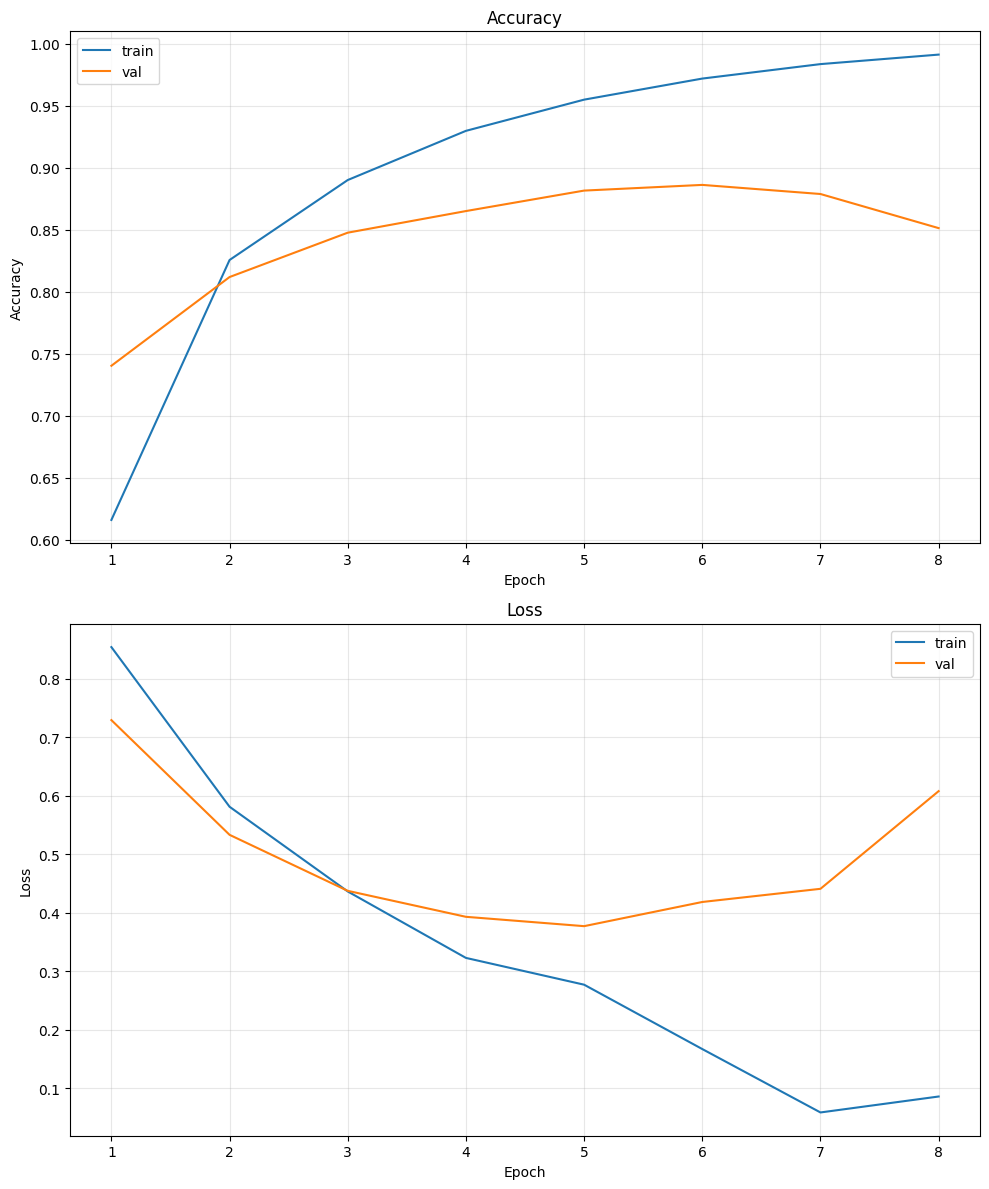

In [53]:
plot_history(history)

In [54]:
# Inference
y_pred = adv_model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Test accuracy: 0.886
              precision    recall  f1-score   support

        ABBR       0.78      0.78      0.78         9
        DESC       0.88      0.98      0.93       138
        ENTY       0.86      0.71      0.78        94
         HUM       0.83      0.88      0.85        65
         LOC       0.85      0.90      0.87        81
         NUM       0.99      0.92      0.95       113

    accuracy                           0.89       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.89      0.89      0.88       500



Topic-wise accuracy on test set:
ABBR: 0.7778 (n=9)
DESC: 0.9783 (n=138)
ENTY: 0.7128 (n=94)
HUM: 0.8769 (n=65)
LOC: 0.9012 (n=81)
NUM: 0.9204 (n=113)


<Figure size 1000x800 with 0 Axes>

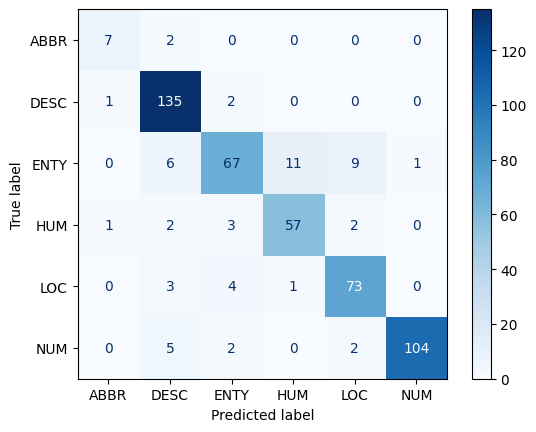

In [55]:
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

print("Topic-wise accuracy on test set:")

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Plot the confusion matrix
plt.figure(figsize=(10,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = le.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [56]:
# Save weights
adv_model.save_weights('bigru_adv_model_v2.weights.h5')